In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

torch.manual_seed(611)

In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'PANNs'#'PANNs'#'YAMNet' #'VGGish'#'AI'
train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

RZUA01
Data1.shape=torch.Size([3, 24, 2048])
RZUA02
Data1.shape=torch.Size([3, 24, 2048])
RZUA04
Data1.shape=torch.Size([3, 24, 2048])
RZUA05
Data1.shape=torch.Size([3, 24, 2048])
RZUA06
Data1.shape=torch.Size([3, 24, 2048])
RZUA07
Data1.shape=torch.Size([3, 24, 2048])
RZUA08
Data1.shape=torch.Size([3, 24, 2048])
RZUA09
Data1.shape=torch.Size([3, 24, 2048])
RZUA10
Data1.shape=torch.Size([3, 24, 2048])
RZUB01
Data1.shape=torch.Size([3, 24, 2048])
RZUB03
Data1.shape=torch.Size([3, 24, 2048])
RZUB04
Data1.shape=torch.Size([3, 24, 2048])
RZUB05
Data1.shape=torch.Size([3, 24, 2048])
RZUB06
Data1.shape=torch.Size([3, 24, 2048])
RZUB07
Data1.shape=torch.Size([3, 24, 2048])
RZUB08
Data1.shape=torch.Size([3, 24, 2048])
RZUB09
Data1.shape=torch.Size([3, 24, 2048])
RZUB10
Data1.shape=torch.Size([3, 24, 2048])
RZUB11
Data1.shape=torch.Size([3, 24, 2048])
RZUC01
Data1.shape=torch.Size([3, 24, 2048])
RZUC02
Data1.shape=torch.Size([3, 24, 2048])
RZUC03
Data1.shape=torch.Size([3, 24, 2048])
RZUC05
Dat

In [6]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [7]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 2048])

## Edge Creation

In [8]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [9]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 606]) connected? True
Is the graph undirected True


2048

In [10]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [11]:
del graphs, x, unpacked_data, train_dataset

In [12]:
features = torch.empty(92,0)
for graph in train_loader:
    features = torch.cat((features,graph.x.flatten(1)), dim = 1)

In [13]:
print(features.shape)
# features = (features - features.min(0).values)/(features.max(0).values - features.min(0).values)

torch.Size([92, 147456])


In [14]:
features = min_max_normalize_along_dim(features,1)

In [15]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [16]:
features

tensor([[0.0000, 0.2096, 0.0000,  ..., 0.9055, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1182, 0.1777, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3890, 0.0000, 0.0000],
        ...,
        [0.0000, 0.1545, 0.0000,  ..., 0.4983, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.6409, 0.0023, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4568, 1.0000, 0.0000]])

In [17]:
sim_mat = (features@features.T)/features.shape[1]
sim_mat

tensor([[0.0396, 0.0247, 0.0236,  ..., 0.0184, 0.0185, 0.0219],
        [0.0247, 0.0354, 0.0219,  ..., 0.0184, 0.0183, 0.0203],
        [0.0236, 0.0219, 0.0357,  ..., 0.0189, 0.0182, 0.0219],
        ...,
        [0.0184, 0.0184, 0.0189,  ..., 0.0330, 0.0198, 0.0195],
        [0.0185, 0.0183, 0.0182,  ..., 0.0198, 0.0313, 0.0191],
        [0.0219, 0.0203, 0.0219,  ..., 0.0195, 0.0191, 0.0340]])

In [18]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [20]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

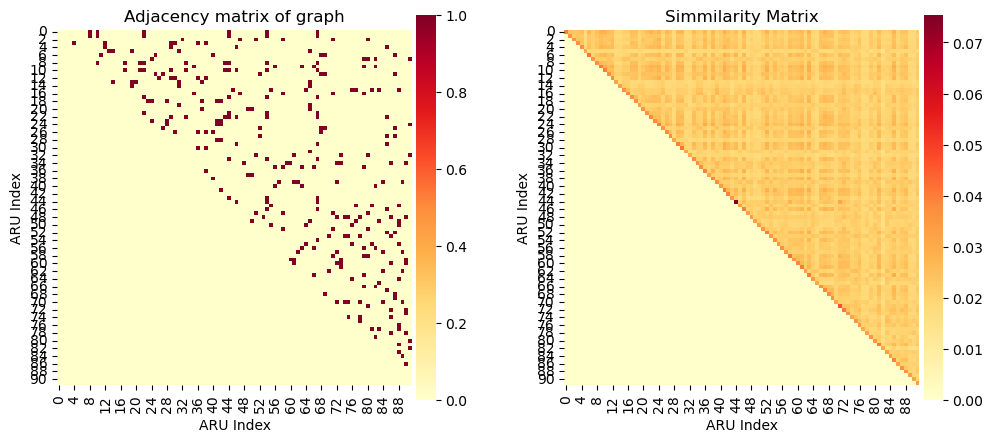

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

## Pre-process graph

In [22]:
graphs_ = edge_creation_nodeinfo(features.unsqueeze(0),'knn', k_neigh=5)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 147456], edge_index=[2, 686]) connected? True
Is the graph undirected True


In [23]:
adj_init = edge_index_to_adjacency(graph.edge_index)
adj_final = edge_index_to_adjacency(graphs_[0].edge_index)

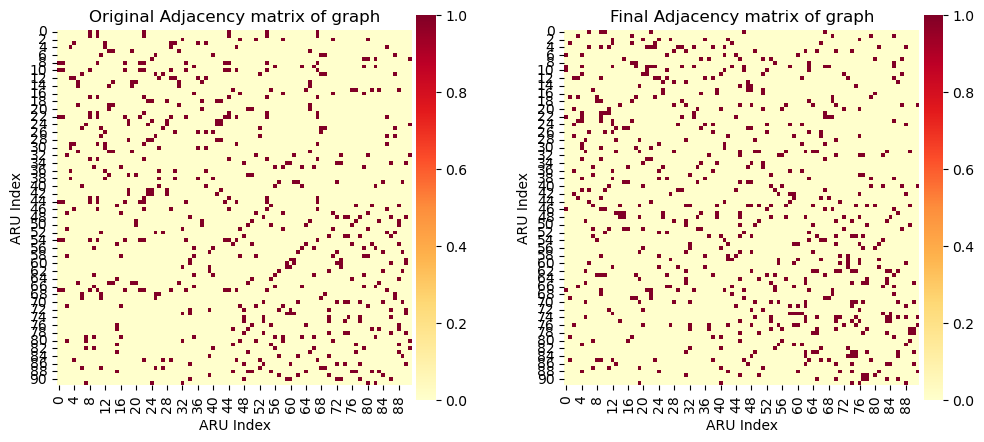

In [24]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(adj_init, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Original Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
# sns.heatmap(adj_final*sim_mat, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
sns.heatmap(adj_final, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Final Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

In [25]:
import networkx as nx

def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges with weights if available
    edges = data.edge_index.t().numpy()
    
    # Check if edge weights are available
    if hasattr(data, 'edge_weight') and data.edge_weight is not None:
        # Add edges with weights
        edge_weights = {tuple(edge): weight.item() for edge, weight in zip(edges, data.edge_weight)}
        for edge, weight in edge_weights.items():
            G.add_edge(edge[0], edge[1], weight=weight)
    else:
        # Add edges without weights
        G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [26]:
import geopandas as gpd

#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

coordinates = same_posicion_data(df_map)

In [27]:
def adjacency_to_edge_weights(adj_matrix, edge_index):
    """
    Convert adjacency matrix of weights to edge_weight tensor using edge_index.
    
    Args:
        adj_matrix: Tensor of shape [num_nodes, num_nodes] containing edge weights
        edge_index: Tensor of shape [2, num_edges] containing edge indices
        
    Returns:
        edge_weight: Tensor of shape [num_edges] containing weights for each edge
    """
    # Get source and target nodes for each edge
    src, dst = edge_index[0], edge_index[1]
    
    # Extract weights from adjacency matrix based on edge indices
    edge_weight = adj_matrix[src, dst]
    
    return edge_weight

In [28]:
edge_weight = adjacency_to_edge_weights(sim_mat, graphs_[0].edge_index)
edge_weight.shape

torch.Size([686])

In [29]:
graphs_[0].edge_weight = edge_weight

In [30]:
G = pyg_to_networkx(graphs_[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [31]:
G.edges(data=True)

EdgeDataView([(0, 6, {'weight': 0.026950018480420113}), (0, 9, {'weight': 0.02847655676305294}), (0, 10, {'weight': 0.027933277189731598}), (0, 22, {'weight': 0.02735856920480728}), (0, 46, {'weight': 0.02809772826731205}), (0, 67, {'weight': 0.027939029037952423}), (1, 3, {'weight': 0.023976681753993034}), (1, 17, {'weight': 0.024440769106149673}), (1, 69, {'weight': 0.02472473494708538}), (1, 79, {'weight': 0.0230448879301548}), (1, 85, {'weight': 0.025274310261011124}), (2, 12, {'weight': 0.025590479373931885}), (2, 20, {'weight': 0.023918185383081436}), (2, 24, {'weight': 0.027394741773605347}), (2, 27, {'weight': 0.02385346032679081}), (2, 36, {'weight': 0.02649001218378544}), (2, 42, {'weight': 0.025633428245782852}), (2, 76, {'weight': 0.02404462918639183}), (3, 12, {'weight': 0.025306515395641327}), (3, 17, {'weight': 0.025637902319431305}), (3, 23, {'weight': 0.025546031072735786}), (3, 43, {'weight': 0.02260587550699711}), (3, 66, {'weight': 0.02472679130733013}), (4, 6, {'we

In [32]:
nx.density(G)


0.08193979933110368

In [41]:
nx.diameter(G,weight="weight")

0.14452141895890236

In [42]:
nx.average_shortest_path_length(G,weight="weight")

0.07098795719377116

In [35]:
# nx.betweenness_centrality(G, weight="weight")

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


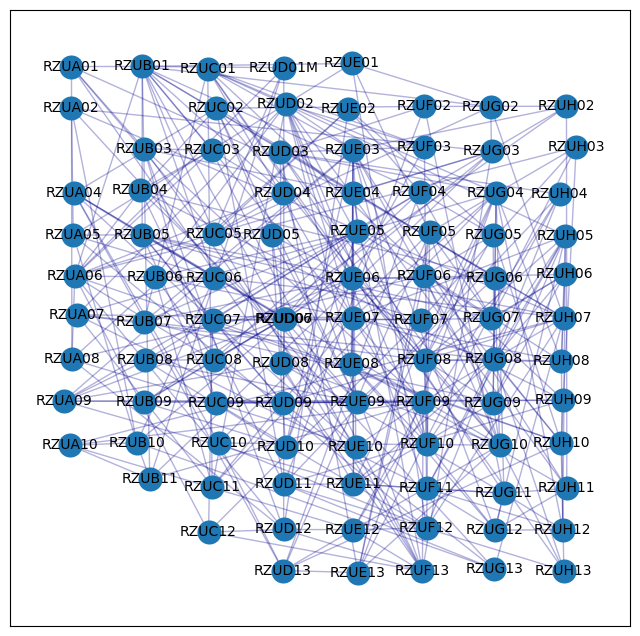

In [36]:
edge_weights = [1 for u, v in G.edges()]
# edge_weights = [3*sim_mat[u,v]  for u, v in G.edges()]

# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

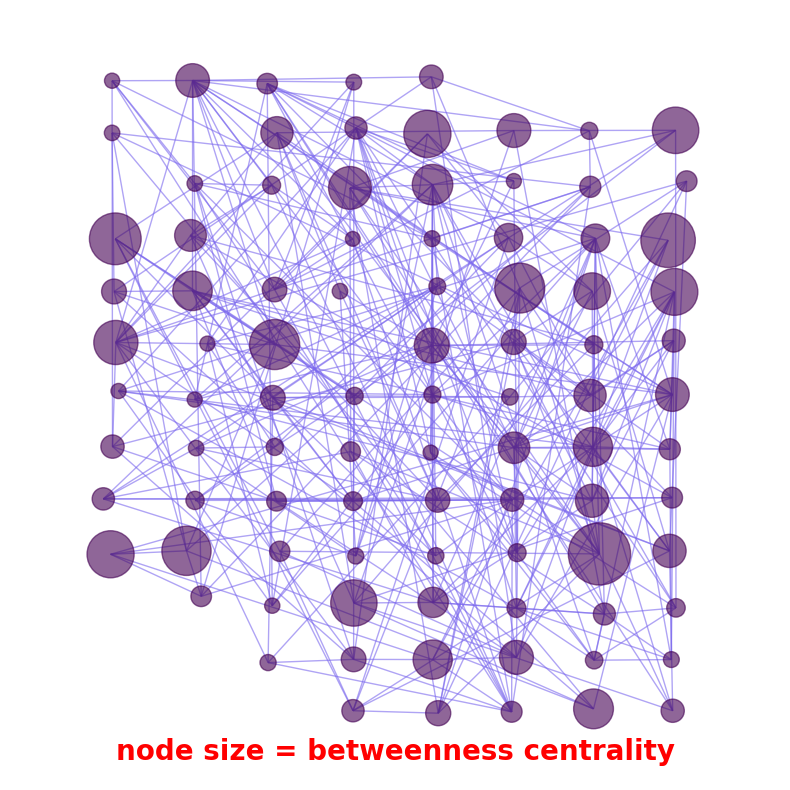

In [37]:
H = G.copy()
H.remove_node(35)
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
    alpha=0.6,
)

# Title/legend
font = {"color": "r", "fontweight": "bold", "fontsize": 20}


ax.text(
    0.50,
    0.026,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

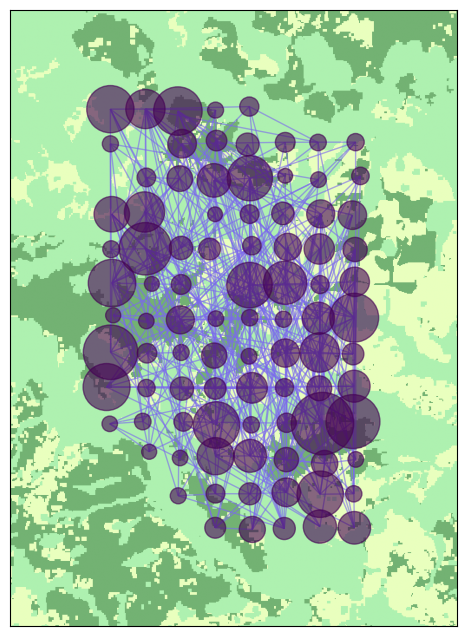

In [38]:
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.plot import show

# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))

colors = [(115/255,178/255,115/255),(233/255,255/255,190/255), (174/255,241/255,176/255)] 
cmap = LinearSegmentedColormap.from_list('my_cmp', colors, N=3)


tif_path = r'./data/wgs84.tif'

img = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize = (8, 8))

# plt.title("COB")
r = rasterio.plot.show(img, cmap=cmap, ax=ax)

# im = r.get_images()[0]
# fig.colorbar(im, ax=ax)

centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
    alpha=0.6,
)


margin = 0.01
ax.set_xlim(bounds[2]-margin, bounds[3]+margin)
ax.set_ylim(bounds[0]-margin, bounds[1]+margin)

# fig.savefig(f'./results/graph_eb_geo_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)
plt.show()


## Fin